##### Deep Learning Tutorial Assignment 2:  Generative Adversarial Networks
_Yoav Rabinovich, November 2019_

### Teaching a Conditional GAN to Read

_____________

In this assignment I trained a cGAN to generate handwritten letters using TensorFlow.

We've been teaching our Neural Networks to read forever, but it's time we stopped neglecting the critical skill of writing. For this task we'll need a generative model which can produce a proper handwritten letter by request.

In contrast to vanilla GANs, a conditional GAN learns not only the distribution that characterizes the dataset, but the distributions that characterize each of the classes in it. As opposed to training separate GANs for each class, a single cGAN generator can learn to produce samples from all classes in a single training session on the entire dataset. Perfect for our purposes.

A cGAN has an indentical structure to a vanilla GAN, but the inputs for the generator and the discriminator are concatenated with an encoded target class. If the generator were to produce otherwise realistic samples that don't correlate with the correct class, the discriminator will be able to recognize them as fake by learning the correlation between the features and the class itself.

Therefore, the model graph and the loss functions need not be modified for the cGAN case. I used cross-entropy loss: 

$$\min_G \max_D V(D, G) = \mathop{\mathbb{E}}_{x \sim p_{data}(x)}[\log D(x|y)] + \mathop{\mathbb{E}}_{z \sim p_z(z)}[\log(1 - D(G(z,y)|y))]$$

For the purpose of this assignment I used the letters subset of EMNIST dataset (extended MNIST). Interestingly, since the capital letters were bunched together with lower case examples, the generator learned that two distributions for each class were permissable.

In some cases, the distributions are very similar ("c" and "C" for example), but in others, we find that the input space was mapped into two separate distributions, such as the case with our last example, that features both lower case and capital versions of "A". Actually, two versions of lower case "a" can be seen there as well, so in some cases more than two distributions we learned. 

In other letters, it seems that there was internal "mode-collapse" in the learned representation for the class: "e" for example, is never seen in its capital form. This might be due to the capital "E" being similar in shape to other letters ("B" for example), which were avoided in favor of distributions more distinct than those of other classes.

This leads to the phenomenon where we see some results that seem like an interpolation of the lower case and capital forms of a letter, but none that interpolate between classes: the latter would've been punished by the discriminator, while the former was allowed. In further work on this problem, separation of the forms into distinct classes is therefore advised, to prevent interpolation.

_Architecture and TensorFlow code adapted from MNIST example in https://wiseodd.github.io/techblog/2016/12/24/conditional-gan-tensorflow/_

_Original cGAN paper https://arxiv.org/abs/1411.1784_

#### Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# !pip install emnist
import emnist
from sklearn.preprocessing import OneHotEncoder
from tensorflow.contrib.learn.python.learn.datasets import mnist
import string

#### Preprocessing

In [0]:
# Extracting data from EMNIST package
em_train_images, em_train_labels = emnist.extract_training_samples('letters')
# Applying one-hot encoding
ohe = OneHotEncoder(26)
em_onehot = ohe.fit_transform(np.subtract(em_train_labels,1).reshape(-1, 1)).toarray()
em_data = em_train_images.reshape((em_train_images.shape[0],em_train_images.shape[1],em_train_images.shape[2],1))
# Using DataSet class from the TF tutorials package for easy batch loading
emnist = mnist.DataSet(em_data,em_onehot,one_hot=True)

#### Graphing the Model

Defining a model graph to run, as a set of nested TensorFlow fuctions:

In [0]:
# Input parameters, according to dataset:
# Shape of data (28 by 28 pixel image)
X_dim = 28**2
# Length of class list (26 letters)
y_dim = 26

# Model parameters, taken from reference:
# Dimension of noise input space for the generator
Z_dim = 100
# Dimension of hidden layers
h_dim = 128

In [0]:
# Defining variables for inputs:
# Data flattened
X = tf.placeholder(tf.float32, shape=[None, X_dim])
# Class encoded as a one-hot vector
y = tf.placeholder(tf.float32, shape=[None, y_dim])
# Noise as input for generator
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

In [0]:
def xavier_init(size):
    """
    Xavier initialization for weights in the network.
    """
    xavier_stddev = 1. / tf.sqrt(size[0] / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [0]:
# Defining weight and bias variables for descriminator hidden and logit layers
D_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))
# Grouping trainable variables for the descriminator
theta_D = [D_W1, D_W2, D_b1, D_b2]

In [0]:
def discriminator(x, y):
    """
    Discriminator structure with one hidden layer:
    The input is an image, real or fake, concatenated with a class label.
    The hidden layer is wrapped in a reLU activation function
    The logit layer output is used for loss calculation
    The logits are then normalized through a sigmoid to produce probabilities
    for possible classification uses.
    """
    inputs = tf.concat(axis=1, values=[x, y])
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [0]:
# Defining weight and bias variables for generator hidden and logit layers
G_W1 = tf.Variable(xavier_init([Z_dim + y_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))
# Grouping trainable variables for the descriminator
theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]

In [0]:
def generator(z, y):
    """
    Generator structure with one hidden layer:
    The input is random noise, concatenated with a class label.
    The hidden layer is wrapped in a reLU activation function
    The logit layer output normalized through a sigmoid to generate fake images.
    """
    inputs = tf.concat(axis=1, values=[z, y])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

In [0]:
# Defining the cross-entropy loss function for each of the networks:
# G_sample is used for fake image generation
G_sample = generator(Z, y)
# D_logit passes an image through the discriminator
_, D_logit_real = discriminator(X, y)
_, D_logit_fake = discriminator(G_sample, y)
# Discriminator loss is the sum of the cross-entropy loss on false positives
# and the cross-entropy loss on false negatives
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
# Generator loss is cross-entropy for true positives
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
# We then minimize the loss functions using Adam optimizers on the defined
# trainable variable groups
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

#### Training the Model

Training according to parameters adapted from the reference. I added an optional parameter for staggering the training of the discriminator, to prevent the common fail-state where a fast-learning discriminator prevents the generator training from taking off. Also tracking losses over time.

In [0]:
# Start TensorFlow training session
sess = tf.Session()
# Initialize variables
sess.run(tf.global_variables_initializer())

# Training parameters
b_size = 32
iterations = 500000
adv_ratio = 1
D_losses = []
G_losses = []

# Training
for i in range(iterations):

    # Minibatches picked randomly without replacement within each epoch
    X_mb, y_mb = emnist.next_batch(b_size)
    # Train generator
    Z_sample = np.random.uniform(-1., 1., [b_size, Z_dim])
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_sample, y:y_mb})
    G_losses.append(G_loss_curr)
    # If the discriminator is to be trained this timestep, do so
    if i % adv_ratio == 0:
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_sample, y:y_mb})
        D_losses.append(D_loss_curr)


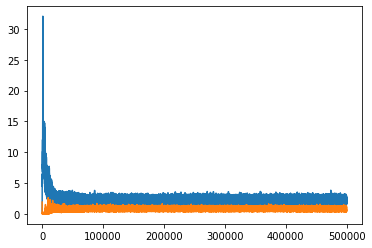

In [0]:
# Plot losses over time, generator loss in blue
plt.plot(np.arange(0,iterations,1),G_losses)
plt.plot(np.arange(0,iterations,adv_ratio),D_losses)

#### Results

Showing off some generated text.

In [0]:
def write_message(message, generator,per_row=10,cmap="gray"):
    """
    Method to convert a string to an image of text generated by the network.
    """
    # Remove capital letters and punctuation.
    parsed = message.translate(str.maketrans('', '', string.punctuation)).lower()
    # Encode letters for 0-26
    encoded = [ord(c)-97 for c in parsed]
    # Arrange in nice square array
    for i in range(len(encoded),len(encoded)+per_row):
        if i%per_row == 0:
            break
        else:
            encoded.append(-1)
    arranged = np.array(encoded).reshape(-1,per_row)
    # Generate image
    image = np.zeros((arranged.shape[0]*28,arranged.shape[1]*28))
    for i, c in np.ndenumerate(arranged):
        # Negative terms correspond to spaces and left as blank arrays
        if c > -1:
            # Sample random noise and concatenate required class
            Z_sample = np.random.uniform(-1., 1., [1, Z_dim])
            y_sample = np.zeros(shape=[1, y_dim])
            y_sample[:,c] = 1
            # Generate letter and set the pixel values in place
            written = sess.run(generator, feed_dict={Z: Z_sample, y:y_sample}).reshape(28,28)
            image[i[0]*28:(i[0]+1)*28,i[1]*28:(i[1]+1)*28] = written
    # Plot image
    plt.axis('off')
    plt.imshow(image,cmap=cmap)

The generator's writing is readable but a bit blurry and inconsistent, so most of the output looks like it was either written by a 6-year-old:

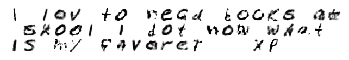

In [0]:
write_message("I lov to read books at skool! I dot now what is my favoret.   XP", G_sample,22,"gray_r")

Or with blood, on a wall:

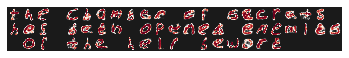

In [0]:
write_message("The Chamber of Secrets has been opened. Enemies of the heir... beware", G_sample,23,"RdGy_r")

But is has one clear message to whoever reads this:

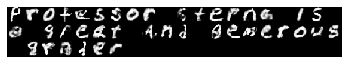

In [0]:
write_message("Professor Sterne is a great and generous grader",G_sample,20)